In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline

In [2]:
img = cv2.imread("../test_img/shibuya_img.jpg")
img.shape

(1500, 1046, 3)

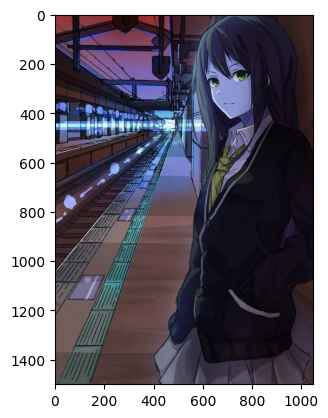

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

(1500, 1046)

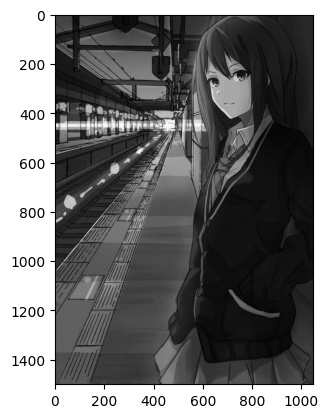

In [5]:
plt.imshow(gray,cmap="gray")

In [6]:
face_casade = cv2.CascadeClassifier("../opencv/lbpcascade_animeface.xml")
eye_casade = cv2.CascadeClassifier("../opencv/anime-eyes-cascade.xml")
faces = face_casade.detectMultiScale(gray,1.3,5)
faces

array([[548, 146, 325, 325]], dtype=int32)

In [7]:
(x,y,w,h) = faces[0]
x,y,w,h

(548, 146, 325, 325)

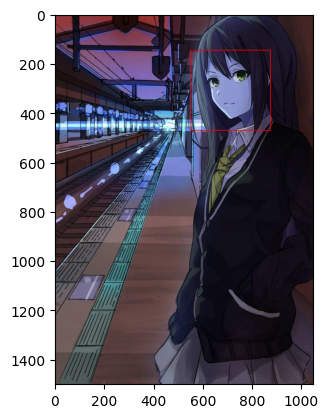

In [8]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

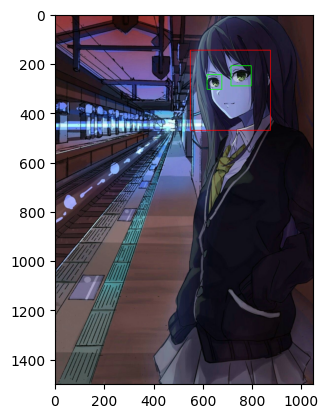

In [9]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = face_img[y:y+h,x:x+w]
    eyes = eye_casade.detectMultiScale(roi_color)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure()
plt.imshow(face_img,cmap="gray")
plt.show()

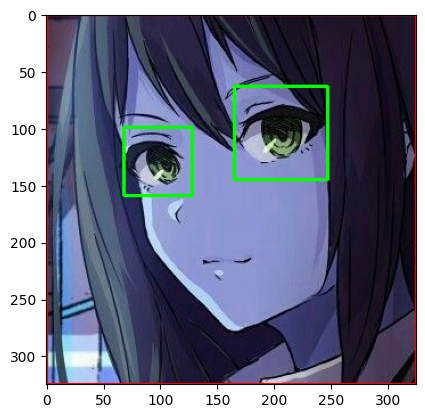

In [10]:
%matplotlib inline
plt.imshow(roi_color,cmap="gray")

In [11]:
cropped_img = np.array(roi_color)
cropped_img.shape

(325, 325, 3)

In [12]:
import pywt
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

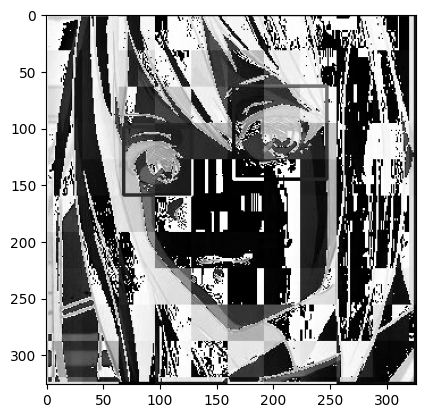

In [13]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har,cmap="gray")

In [14]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_casade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_casade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

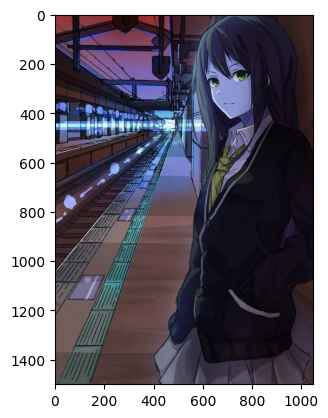

In [15]:
original_image = cv2.imread("../test_img/shibuya_img.jpg")
plt.imshow(original_image)

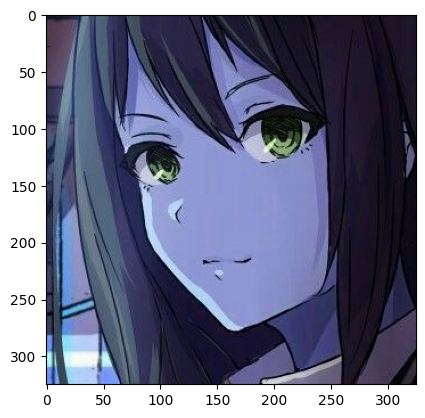

In [16]:
cropped_img = get_cropped_image_if_2_eyes("../test_img/shibuya_img.jpg")
plt.imshow(cropped_img)

In [17]:
cropped_img_non_eyes = get_cropped_image_if_2_eyes("../test_img/non_eye.jpg")
cropped_img_non_eyes

## Data Cleaning

In [18]:
path_to_data = "../dataset/"
path_to_cr_data = "../dataset/cropped/"
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
print(img_dirs)

['../dataset/Takina_Inoue', '../dataset/Shibuya_rin']


In [19]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [20]:
waifu_file_names_dict = {}

for img_dir in img_dirs:
    waifu_name = os.path.basename(img_dir)
    print(f"Waifu name: {waifu_name}")
    waifu_file_names_dict[waifu_name] = []
    
    cropped_folder = os.path.join(path_to_cr_data, waifu_name)
    os.makedirs(cropped_folder, exist_ok=True)
    print("Generating cropped images in folder:", cropped_folder)
    
    for count, entry in enumerate(os.scandir(img_dir), 1):
        if entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png')):
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_file_name = f"{waifu_name}_{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                
                cv2.imwrite(cropped_file_path, roi_color)
                waifu_file_names_dict[waifu_name].append(cropped_file_path)


Waifu name: Takina_Inoue
Generating cropped images in folder: ../dataset/cropped/Takina_Inoue


Waifu name: Shibuya_rin
Generating cropped images in folder: ../dataset/cropped/Shibuya_rin


In [21]:
print(len(os.listdir("../dataset/cropped/Shibuya_rin")))
print(len(os.listdir("../dataset/cropped/Takina_Inoue")))

30
34


In [22]:
print(len(os.listdir("../dataset/Shibuya_rin/")))
print(len(os.listdir("../dataset/Takina_Inoue/")))

70
58


In [23]:
class_dict = {}
count = 0
for celebrity_name in waifu_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Takina_Inoue': 0, 'Shibuya_rin': 1}

### Using Raw Imagies along with wavelet transformed images to train our classifier.

In [24]:
waifu_file_names_dict

{'Takina_Inoue': ['../dataset/cropped/Takina_Inoue/Takina_Inoue_1.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_3.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_5.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_6.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_7.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_11.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_12.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_13.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_15.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_17.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_18.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_19.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_21.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_22.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_25.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_26.png',
  '../dataset/cropped/Takina_Inoue/Takina_Inoue_27.png',
  '../dataset/croppe

In [25]:
# X, y = [], []
# for waifu_name,training_files in waifu_file_names_dict.items():
#     for training_image in training_files:
#         img = cv2.imread(training_image)
#         scalled_raw_img = cv2.resize(img,(32,32))
#         img_hair = w2d(img,"db1",5)
#         scalled_img_har = cv2.resize(im_har,(32,32))
#         combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
#         X.append(combined_img)
#         y.append(class_dict[waifu_name])
X, y,flatten = [], [], []

# Daftar kategori waifu
waifu_categories = ['Takina_Inoue', 'Shibuya_rin']

# Loop melalui setiap kategori waifu
for waifu_name in waifu_categories:
    # Ambil daftar file pelatihan untuk kategori waifu saat ini
    training_files = ['../dataset/' + waifu_name + '/' + img_file for img_file in os.listdir('../dataset/' + waifu_name)]
    
    # Loop melalui setiap file pelatihan
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_hair = w2d(img, "db1", 5)
        scalled_img_har = cv2.resize(img_hair, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32 * 32 * 3, 1), scalled_img_har.reshape(32 * 32, 1)))
        X.append(combined_img)
        flatten.append(combined_img.flatten())
        y.append(waifu_categories.index(waifu_name))

In [26]:
np.array(X).shape
# np.array(y)

(128, 4096, 1)

In [27]:
import pandas as pd
df = pd.DataFrame(np.array(flatten))
target = y
df["target"] = target


In [28]:
df.to_csv("takina_shibuya_dataset.csv")

In [29]:
y[0]

0

In [30]:
X = df.values
y = target

In [31]:
# X= np.array(X).reshape(len(X),4096).astype(float)

# y = np.array(y).reshape(len(y),-1)


## Data Cleaning Process is done. we fuckinf train our model

In [32]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,test_size = 0.2,random_state=109,stratify=y)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7307692307692307

In [34]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.73      0.79      0.76        14

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



In [35]:
model_params = {
    'svm': {
        'model': SVC(),
        'params': {
            'svc__C': [1, 10, 100, 1000],
            'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
            'svc__gamma': ['scale', 'auto'],
            'svc__probability': [False, True],
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1, 5, 10, 100],
            'randomforestclassifier__max_features': ['sqrt', 'log2'],
            'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10, 100],
            'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
        }
    }
}

In [36]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/home/kayaba/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kayaba/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kayaba/.local/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/kayaba/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last

KeyboardInterrupt: 

that score in manchine learning,how in deep learning

In [ ]:
best_model = df["best_score"].idxmax()
name_model = df["model"].loc[best_model]
name_model

'svm'

In [ ]:
best_model = best_estimators[name_model]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
cm


array([[ 8,  4],
       [ 3, 11]])

Text(95.72222222222221, 0.5, 'Truth')

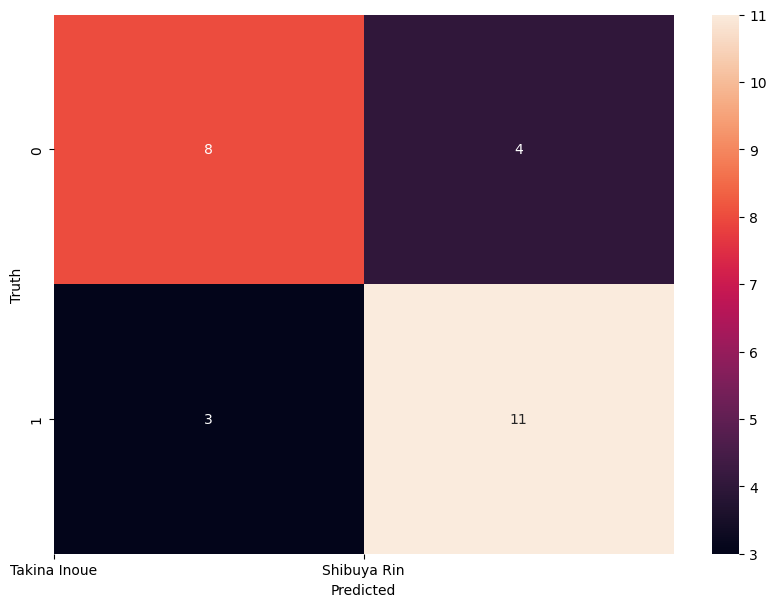

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xticks([0,1],["Takina Inoue","Shibuya Rin"])
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
import joblib
joblib.dump(best_model,"saved_model.pkl")

['saved_model.pkl']

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, best_model.predict(X_test))

0.7307692307692307

In [ ]:
np.unique(y)

array([0, 1])